In [1]:
import logging

from live2p.workers import RealTimeQueue
from live2p.utils import get_nchannels, get_nvols, get_tslice, ptoc, slice_movie, tic
from live2p.offline import run_plane_offline

# logging setup
# change for more or less information...
caiman_loglevel = logging.WARNING
live2p_loglevel = logging.DEBUG

logformat = '{relativeCreated:08.0f} - {levelname:8} - [{module}:{funcName}:{lineno}] - {message}'
logging.basicConfig(level=caiman_loglevel, format=logformat, style='{') #sets caiman loglevel
logger = logging.getLogger('live2p')
logger.setLevel(live2p_loglevel) # sets live2p debug level

In [2]:
# experiment info
tiff_folder = 'e:/caiman_scratch/test_data/ori/data'
plane = 0 # index starts at 0

# these need to match what was in makeMasks3D
# if you get a 'ValueError: Error while saving neurons_sn.' these are set 
# incorrectly (mismatched with what make_Masks3D was)
# sorry, I don't have a good way to do this automatically for offline
x_start = 110
x_end = 512-110

# pre-allocated frame buffer
max_frames = 30000

n_init = 500

In [3]:
params = {
    'fr': 6.36,
    'p': 1,  # deconv 0 is off, 1 is slow, 2 is fast
    'nb': 3,  # background compenents -> nb: 3 for complex
    'decay_time': 1.0,  # sensor tau
    'gSig': (7, 7),  # expected half size of neurons in pixels, very important for proper component detection
    'init_method': 'seeded',
    'motion_correct': True,
    'expected_comps': 300,
    'update_num_comps': False,
    'update_freq': 100,
    'niter_rig': 2,
    'pw_rigid': False,
    'dist_shape_update': False,
    'normalize': True,
    'sniper_mode': False,
    'test_both': False,
    'ring_CNN': False,
    'simultaneously': True,
    'use_cuda': False,
}

In [4]:
# run a single plane offline
# result = run_plane_offline(plane, tiff_folder, params, x_start, x_end, n_init, max_frames)

In [5]:
# run all planes offline
# as run_plane_offline is already multi-process, so the simplest way to do this is to run planes sequentially
nplanes = 3

data = []
for p in range(nplanes):
    print(f'***** Starting Plane {p} *****')
    result = run_plane_offline(p, tiff_folder, params, x_start, x_end, n_init, max_frames)
    data.append(result)
print('All done!')

***** Starting Plane 0 *****
getting files for initialization....


00086344 - DEBUG    - [workers:__init__:45] - Setting up params...
00086396 - DEBUG    - [workers:_setup_folders:106] - Set temp_path to e:\caiman_scratch\test_data\ori\data\live2p\tmp
00086399 - DEBUG    - [workers:_setup_folders:109] - Set out_path to e:\caiman_scratch\test_data\ori\data\live2p\out
00086402 - DEBUG    - [workers:_setup_folders:113] - Set working dir to e:\caiman_scratch\test_data\ori\data\live2p\tmp


starting initialization...


00086731 - INFO     - [workers:__init__:206] - Starting live2p worker.
00086731 - INFO     - [workers:__init__:215] - Starting new OnACID initialization for live2p.
00086731 - DEBUG    - [workers:make_init_mmap:221] - Making init memmap...


Plane 0: Found 99 sources from MM3D...


00089529 - DEBUG    - [workers:make_init_mmap:238] - Init mmap saved to initplane0_d1_512_d2_292_d3_1_order_C_frames_500_.mmap.
00091836 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00091907 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
00097687 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00103493 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
C:\Users\Will\miniconda3\envs\live2p\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
00120099 - INFO     - [workers:save_acid:437] - Saved OnACID hdf5 to e:\caiman_scratch\test_data\ori\live2p_init\realtime_init_plane_0.hdf5
00120102 - DEBUG    - [workers:initialize:269] - OnACID initialized.
0

starting queue...
starting worker...


00154379 - INFO     - [workers:process_frame_from_queue:341] - Total of 1000 frames processed. (Queue 0)
00154379 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 85 ms. (11.67 Hz) (Queue 0)
00175968 - INFO     - [workers:process_frame_from_queue:341] - Total of 1500 frames processed. (Queue 0)
00175973 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 85 ms. (11.69 Hz) (Queue 0)
00197578 - INFO     - [workers:process_frame_from_queue:341] - Total of 2000 frames processed. (Queue 0)
00197580 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 91 ms. (10.88 Hz) (Queue 0)
00219089 - INFO     - [workers:process_frame_from_queue:341] - Total of 2500 frames processed. (Queue 0)
00219089 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 91 ms. (10.91 Hz) (Queue 0)
00240680 - INFO     - [workers:process_frame_from_queue:341] - Total of 3000 frames processed. (Queue 0)
00240690 - 

done!


00389145 - DEBUG    - [workers:_stop_cluster:97] - Cluster stopped.
00389155 - DEBUG    - [workers:__del__:75] - Worker object destroyed on delete.


***** Starting Plane 1 *****
getting files for initialization....


00390154 - DEBUG    - [workers:__init__:45] - Setting up params...
00390210 - DEBUG    - [workers:_setup_folders:106] - Set temp_path to e:\caiman_scratch\test_data\ori\data\live2p\tmp
00390213 - DEBUG    - [workers:_setup_folders:109] - Set out_path to e:\caiman_scratch\test_data\ori\data\live2p\out
00390216 - DEBUG    - [workers:_setup_folders:113] - Set working dir to e:\caiman_scratch\test_data\ori\data\live2p\tmp


starting initialization...


00390516 - INFO     - [workers:__init__:206] - Starting live2p worker.
00390518 - INFO     - [workers:__init__:215] - Starting new OnACID initialization for live2p.
00390522 - DEBUG    - [workers:make_init_mmap:221] - Making init memmap...


Plane 1: Found 111 sources from MM3D...


00393405 - DEBUG    - [workers:make_init_mmap:238] - Init mmap saved to initplane1_d1_512_d2_292_d3_1_order_C_frames_500_.mmap.
00395497 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00395569 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
00401011 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00401082 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
00406480 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00406557 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
C:\Users\Will\miniconda3\envs\live2p\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
00

starting queue...
starting worker...


00456328 - INFO     - [workers:process_frame_from_queue:341] - Total of 1000 frames processed. (Queue 1)
00456329 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 84 ms. (11.77 Hz) (Queue 1)
00478082 - INFO     - [workers:process_frame_from_queue:341] - Total of 1500 frames processed. (Queue 1)
00478083 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 88 ms. (11.36 Hz) (Queue 1)
00499777 - INFO     - [workers:process_frame_from_queue:341] - Total of 2000 frames processed. (Queue 1)
00499778 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 84 ms. (11.78 Hz) (Queue 1)
00521412 - INFO     - [workers:process_frame_from_queue:341] - Total of 2500 frames processed. (Queue 1)
00521413 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 92 ms. (10.86 Hz) (Queue 1)
00543041 - INFO     - [workers:process_frame_from_queue:341] - Total of 3000 frames processed. (Queue 1)
00543043 - 

done!


00694443 - DEBUG    - [workers:_stop_cluster:97] - Cluster stopped.
00694453 - DEBUG    - [workers:__del__:75] - Worker object destroyed on delete.


***** Starting Plane 2 *****
getting files for initialization....


00695433 - DEBUG    - [workers:__init__:45] - Setting up params...
00695489 - DEBUG    - [workers:_setup_folders:106] - Set temp_path to e:\caiman_scratch\test_data\ori\data\live2p\tmp
00695489 - DEBUG    - [workers:_setup_folders:109] - Set out_path to e:\caiman_scratch\test_data\ori\data\live2p\out
00695501 - DEBUG    - [workers:_setup_folders:113] - Set working dir to e:\caiman_scratch\test_data\ori\data\live2p\tmp


starting initialization...


00695802 - INFO     - [workers:__init__:206] - Starting live2p worker.
00695804 - INFO     - [workers:__init__:215] - Starting new OnACID initialization for live2p.
00695808 - DEBUG    - [workers:make_init_mmap:221] - Making init memmap...


Plane 2: Found 104 sources from MM3D...


00698687 - DEBUG    - [workers:make_init_mmap:238] - Init mmap saved to initplane2_d1_512_d2_292_d3_1_order_C_frames_500_.mmap.
00700840 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00700911 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
00706416 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00706488 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
00711918 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
00711993 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
C:\Users\Will\miniconda3\envs\live2p\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
00

starting queue...
starting worker...


00760998 - INFO     - [workers:process_frame_from_queue:341] - Total of 1000 frames processed. (Queue 2)
00760998 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 83 ms. (11.92 Hz) (Queue 2)
00782618 - INFO     - [workers:process_frame_from_queue:341] - Total of 1500 frames processed. (Queue 2)
00782620 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 82 ms. (12.07 Hz) (Queue 2)
00804287 - INFO     - [workers:process_frame_from_queue:341] - Total of 2000 frames processed. (Queue 2)
00804287 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 83 ms. (11.92 Hz) (Queue 2)
00825936 - INFO     - [workers:process_frame_from_queue:341] - Total of 2500 frames processed. (Queue 2)
00825937 - INFO     - [workers:process_frame_from_queue:345] - Average processing time: 84 ms. (11.85 Hz) (Queue 2)
00847634 - INFO     - [workers:process_frame_from_queue:341] - Total of 3000 frames processed. (Queue 2)
00847634 - 

done!


00996917 - DEBUG    - [workers:_stop_cluster:97] - Cluster stopped.
00996927 - DEBUG    - [workers:__del__:75] - Worker object destroyed on delete.


All done!


### Once that is all done the data is return into  a list of  python dictionaries

In [9]:
data[0].keys()

dict_keys(['plane', 't', 'A', 'b', 'C', 'f', 'nC', 'YrA', 'CoM'])

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
c = np.concatenate([dat['C'] for dat in data])
nC = np.concatenate([dat['nC'] for dat in data])
a = np.hstack([dat['A'] for dat in data])

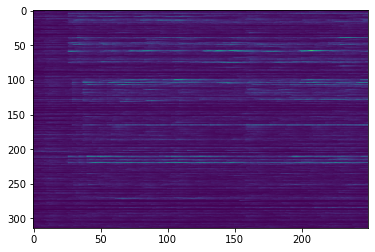

In [27]:
plt.imshow(c[:,:250], aspect='auto')

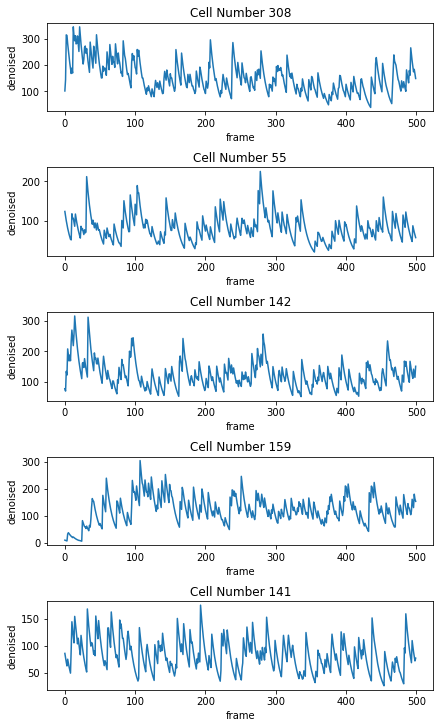

In [40]:
randcells = np.random.choice(np.arange(c.shape[0]), 5, replace=False)
fig, axes = plt.subplots(5,1, constrained_layout=True, figsize=(6,10))

for ax,rc in zip(axes, randcells):
    ax.plot(c[rc, :500])
    ax.set_title(f'Cell Number {rc}')
    ax.set_ylabel('denoised')
    ax.set_xlabel('frame')

In [47]:
a2 = a.reshape((512, 292, 314), order='F')
a2.shape

(512, 292, 314)

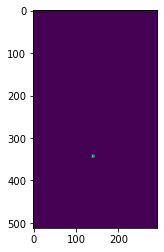

In [48]:
plt.imshow(a2[:,:,0])

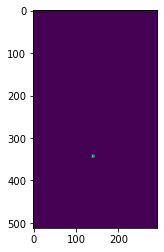

In [49]:
a_list = a2.tolist()
a3 = np.array(a_list)
plt.imshow(a3[:,:,0])